<a href="https://colab.research.google.com/github/DreamWalker1412/Colab/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
from keras.datasets import mnist
from keras.layers import Dense,Dropout,Input
from keras.models import Model,Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import pandas_profiling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
def load_data():
  (X_train,y_train),( _ ,_ ) = mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5)/127.5
  X_train = X_train.reshape(60000, 784)
  
  return (X_train,y_train)

X_train,y_train = load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [ ]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.152941,0.976471,-0.670588,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
pd.DataFrame(y_train).head()

,0
0,5
1,0
2,4
3,1
4,9


In [ ]:
def build_generator():
  model = Sequential(name='generator')

  model.add(Dense(units=256,input_dim=100))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dense(units=512))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dense(units=1024))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dense(units=784,activation='tanh'))

  model.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5))
  return model

generator = build_generator()
generator.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
________________________

In [ ]:
def build_discriminator():
  model = Sequential(name='discriminator')
  
  model.add(Dense(units=1024,input_dim=784))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Dense(units=512))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Dense(units=256))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))

  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5))
  return model

discriminator = build_discriminator()
discriminator.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
___

In [ ]:
def build_GAN(discriminator,generator):
  discriminator.trainable = False
  GAN_input = Input(name='input',shape=(100,))
  x = generator(GAN_input)
  GAN_output = discriminator(x)
  GAN = Model(name='GAN',inputs=GAN_input, outputs=GAN_output)
  GAN.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5))
  return GAN

GAN = build_GAN(discriminator,generator)
GAN.summary()

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 100)               0         
_________________________________________________________________
generator (Sequential)       (None, 784)               1486352   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [ ]:
def draw_images(generator,epoch,examples=25,dim=(5,5),figsize=(10,10)):
  noise = np.random.normal(size=(examples,100))
  generated_images = generator.predict(noise)
  generated_images = generated_images.reshape(25,28,28)
  plt.figure(figsize=figsize)
  for i in range(generated_images.shape[0]):
    plt.subplot(dim[0],dim[1],i+1)
    plt.imshow(generated_images[i],interpolation='nearest',cmap='Greys')
    plt.axis('off')
  plt.tight_layout()
  plt.savefig('Generated_images %d.png' %epoch)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


  5%|▌         | 7/128 [00:00<00:01, 67.93it/s]

Epoch 2


  5%|▌         | 7/128 [00:00<00:01, 66.75it/s]

Epoch 3


  5%|▌         | 7/128 [00:00<00:01, 64.94it/s]

Epoch 4


  5%|▌         | 7/128 [00:00<00:01, 67.80it/s]

Epoch 5


  5%|▌         | 7/128 [00:00<00:01, 67.65it/s]

Epoch 6


  5%|▌         | 7/128 [00:00<00:01, 62.85it/s]

Epoch 7


  5%|▌         | 7/128 [00:00<00:01, 62.56it/s]

Epoch 8


  5%|▌         | 7/128 [00:00<00:01, 65.55it/s]

Epoch 9


  5%|▌         | 7/128 [00:00<00:01, 69.75it/s]

Epoch 10


  5%|▌         | 7/128 [00:00<00:01, 67.71it/s]

Epoch 11


  5%|▌         | 7/128 [00:00<00:01, 67.99it/s]

Epoch 12


  5%|▌         | 7/128 [00:00<00:01, 69.62it/s]

Epoch 13


  6%|▋         | 8/128 [00:00<00:01, 72.69it/s]

Epoch 14


  5%|▌         | 7/128 [00:00<00:01, 67.92it/s]

Epoch 15


  5%|▌         | 7/128 [00:00<00:01, 64.94it/s]

Epoch 16


  5%|▌         | 7/128 [00:00<00:01, 64.63it/s]

Epoch 17


  5%|▌         | 7/128 [00:00<00:01, 65.03it/s]

Epoch 18


  5%|▌         | 7/128 [00:00<00:01, 66.74it/s]

Epoch 19


  5%|▌         | 7/128 [00:00<00:01, 66.42it/s]

Epoch 20


  5%|▌         | 7/128 [00:00<00:01, 65.53it/s]

Epoch 21


  5%|▌         | 7/128 [00:00<00:01, 66.55it/s]

Epoch 22


  6%|▋         | 8/128 [00:00<00:01, 71.97it/s]

Epoch 23


  5%|▌         | 7/128 [00:00<00:01, 61.91it/s]

Epoch 24


  5%|▌         | 7/128 [00:00<00:01, 69.16it/s]

Epoch 25


  5%|▌         | 7/128 [00:00<00:01, 67.35it/s]

Epoch 26


  5%|▌         | 7/128 [00:00<00:01, 63.58it/s]

Epoch 27


  5%|▌         | 7/128 [00:00<00:01, 68.93it/s]

Epoch 28


  6%|▋         | 8/128 [00:00<00:01, 71.27it/s]

Epoch 29


  6%|▋         | 8/128 [00:00<00:01, 68.51it/s]

Epoch 30


  5%|▌         | 7/128 [00:00<00:01, 63.48it/s]

Epoch 31


  5%|▌         | 7/128 [00:00<00:01, 68.76it/s]

Epoch 32


  5%|▌         | 7/128 [00:00<00:01, 65.90it/s]

Epoch 33


  5%|▌         | 7/128 [00:00<00:01, 69.07it/s]

Epoch 34


  5%|▌         | 7/128 [00:00<00:01, 64.75it/s]

Epoch 35


  6%|▋         | 8/128 [00:00<00:01, 71.50it/s]

Epoch 36


  5%|▌         | 7/128 [00:00<00:01, 69.57it/s]

Epoch 37


  5%|▌         | 7/128 [00:00<00:01, 68.21it/s]

Epoch 38


  6%|▋         | 8/128 [00:00<00:01, 71.05it/s]

Epoch 39


  5%|▌         | 7/128 [00:00<00:01, 69.14it/s]

Epoch 40


  5%|▌         | 7/128 [00:00<00:01, 68.46it/s]

Epoch 41


  5%|▌         | 7/128 [00:00<00:01, 66.75it/s]

Epoch 42


  5%|▌         | 7/128 [00:00<00:01, 65.55it/s]

Epoch 43


  6%|▋         | 8/128 [00:00<00:01, 72.68it/s]

Epoch 44


  5%|▌         | 7/128 [00:00<00:01, 68.66it/s]

Epoch 45


  5%|▌         | 7/128 [00:00<00:01, 69.30it/s]

Epoch 46


  5%|▌         | 7/128 [00:00<00:01, 67.04it/s]

Epoch 47


  5%|▌         | 7/128 [00:00<00:01, 68.72it/s]

Epoch 48


  5%|▌         | 7/128 [00:00<00:01, 63.20it/s]

Epoch 49


  6%|▋         | 8/128 [00:00<00:01, 71.46it/s]

Epoch 50


  5%|▌         | 7/128 [00:00<00:01, 67.97it/s]

Epoch 51


  5%|▌         | 7/128 [00:00<00:01, 69.06it/s]

Epoch 52


  5%|▌         | 7/128 [00:00<00:01, 67.73it/s]

Epoch 53


  6%|▋         | 8/128 [00:00<00:01, 71.37it/s]

Epoch 54


  5%|▌         | 7/128 [00:00<00:01, 69.33it/s]

Epoch 55


  5%|▌         | 7/128 [00:00<00:01, 65.93it/s]

Epoch 56


  5%|▌         | 7/128 [00:00<00:01, 66.61it/s]

Epoch 57


  5%|▌         | 7/128 [00:00<00:01, 65.82it/s]

Epoch 58


  5%|▌         | 7/128 [00:00<00:01, 66.41it/s]

Epoch 59


  5%|▌         | 7/128 [00:00<00:01, 69.86it/s]

Epoch 60


  5%|▌         | 7/128 [00:00<00:01, 66.72it/s]

Epoch 61


  5%|▌         | 7/128 [00:00<00:01, 61.83it/s]

Epoch 62


  5%|▌         | 7/128 [00:00<00:01, 68.44it/s]

Epoch 63


  5%|▌         | 7/128 [00:00<00:01, 67.78it/s]

Epoch 64


  5%|▌         | 7/128 [00:00<00:01, 66.99it/s]

Epoch 65


  5%|▌         | 7/128 [00:00<00:01, 65.60it/s]

Epoch 66


  6%|▋         | 8/128 [00:00<00:01, 70.66it/s]

Epoch 67


  6%|▋         | 8/128 [00:00<00:01, 72.55it/s]

Epoch 68


  6%|▋         | 8/128 [00:00<00:01, 72.26it/s]

Epoch 69


  5%|▌         | 7/128 [00:00<00:01, 67.00it/s]

Epoch 70


  6%|▋         | 8/128 [00:00<00:01, 70.61it/s]

Epoch 71


  5%|▌         | 7/128 [00:00<00:01, 69.19it/s]

Epoch 72


  6%|▋         | 8/128 [00:00<00:01, 70.79it/s]

Epoch 73


  5%|▌         | 7/128 [00:00<00:01, 68.25it/s]

Epoch 74


  5%|▌         | 7/128 [00:00<00:01, 67.75it/s]

Epoch 75


  5%|▌         | 7/128 [00:00<00:01, 66.21it/s]

Epoch 76


  5%|▌         | 7/128 [00:00<00:01, 67.17it/s]

Epoch 77


  5%|▌         | 7/128 [00:00<00:01, 69.81it/s]

Epoch 78


  6%|▋         | 8/128 [00:00<00:01, 72.58it/s]

Epoch 79


  5%|▌         | 7/128 [00:00<00:01, 69.16it/s]

Epoch 80


  5%|▌         | 7/128 [00:00<00:01, 68.10it/s]

Epoch 81


  6%|▋         | 8/128 [00:00<00:01, 71.54it/s]

Epoch 82


  6%|▋         | 8/128 [00:00<00:01, 71.32it/s]

Epoch 83


  5%|▌         | 7/128 [00:00<00:01, 68.99it/s]

Epoch 84


  6%|▋         | 8/128 [00:00<00:01, 70.72it/s]

Epoch 85


  5%|▌         | 7/128 [00:00<00:01, 69.20it/s]

Epoch 86


  5%|▌         | 7/128 [00:00<00:01, 64.37it/s]

Epoch 87


  5%|▌         | 7/128 [00:00<00:01, 69.23it/s]

Epoch 88


  5%|▌         | 7/128 [00:00<00:01, 65.07it/s]

Epoch 89


  5%|▌         | 7/128 [00:00<00:01, 66.10it/s]

Epoch 90


  6%|▋         | 8/128 [00:00<00:01, 71.18it/s]

Epoch 91


  6%|▋         | 8/128 [00:00<00:01, 70.96it/s]

Epoch 92


  6%|▋         | 8/128 [00:00<00:01, 69.89it/s]

Epoch 93


  6%|▋         | 8/128 [00:00<00:01, 71.66it/s]

Epoch 94


  5%|▌         | 7/128 [00:00<00:01, 68.54it/s]

Epoch 95


  6%|▋         | 8/128 [00:00<00:01, 73.00it/s]

Epoch 96


  5%|▌         | 7/128 [00:00<00:01, 67.08it/s]

Epoch 97


  6%|▋         | 8/128 [00:00<00:01, 72.08it/s]

Epoch 98


  5%|▌         | 7/128 [00:00<00:01, 67.78it/s]

Epoch 99


  5%|▌         | 7/128 [00:00<00:01, 65.95it/s]

Epoch 100


  6%|▋         | 8/128 [00:00<00:01, 74.12it/s]

Epoch 101


  6%|▋         | 8/128 [00:00<00:01, 70.92it/s]

Epoch 102


  6%|▋         | 8/128 [00:00<00:01, 72.86it/s]

Epoch 103


  5%|▌         | 7/128 [00:00<00:01, 67.33it/s]

Epoch 104


  5%|▌         | 7/128 [00:00<00:01, 68.05it/s]

Epoch 105


  5%|▌         | 7/128 [00:00<00:01, 69.37it/s]

Epoch 106


  6%|▋         | 8/128 [00:00<00:01, 70.31it/s]

Epoch 107


  5%|▌         | 7/128 [00:00<00:01, 69.46it/s]

Epoch 108


  6%|▋         | 8/128 [00:00<00:01, 71.11it/s]

Epoch 109


  5%|▌         | 7/128 [00:00<00:01, 67.74it/s]

Epoch 110


  5%|▌         | 7/128 [00:00<00:01, 68.11it/s]

Epoch 111


  6%|▋         | 8/128 [00:00<00:01, 73.78it/s]

Epoch 112


  5%|▌         | 7/128 [00:00<00:01, 67.59it/s]

Epoch 113


  6%|▋         | 8/128 [00:00<00:01, 71.43it/s]

Epoch 114


  6%|▋         | 8/128 [00:00<00:01, 71.49it/s]

Epoch 115


  6%|▋         | 8/128 [00:00<00:01, 72.76it/s]

Epoch 116


  5%|▌         | 7/128 [00:00<00:01, 68.31it/s]

Epoch 117


  5%|▍         | 6/128 [00:00<00:02, 57.69it/s]

Epoch 118


  5%|▌         | 7/128 [00:00<00:01, 68.16it/s]

Epoch 119


  6%|▋         | 8/128 [00:00<00:01, 72.82it/s]

Epoch 120


  5%|▌         | 7/128 [00:00<00:01, 69.63it/s]

Epoch 121


  5%|▌         | 7/128 [00:00<00:01, 69.96it/s]

Epoch 122


  6%|▋         | 8/128 [00:00<00:01, 74.82it/s]

Epoch 123


  5%|▌         | 7/128 [00:00<00:01, 66.83it/s]

Epoch 124


  6%|▋         | 8/128 [00:00<00:01, 72.32it/s]

Epoch 125


  5%|▌         | 7/128 [00:00<00:01, 66.10it/s]

Epoch 126


  5%|▌         | 7/128 [00:00<00:01, 68.81it/s]

Epoch 127


  6%|▋         | 8/128 [00:00<00:01, 74.66it/s]

Epoch 128


  5%|▌         | 7/128 [00:00<00:01, 68.91it/s]

Epoch 129


  6%|▋         | 8/128 [00:00<00:01, 72.50it/s]

Epoch 130


  5%|▌         | 7/128 [00:00<00:01, 69.01it/s]

Epoch 131


  5%|▌         | 7/128 [00:00<00:01, 63.80it/s]

Epoch 132


  5%|▌         | 7/128 [00:00<00:01, 64.10it/s]

Epoch 133


  5%|▌         | 7/128 [00:00<00:01, 66.91it/s]

Epoch 134


  6%|▋         | 8/128 [00:00<00:01, 72.74it/s]

Epoch 135


  6%|▋         | 8/128 [00:00<00:01, 70.91it/s]

Epoch 136


  5%|▌         | 7/128 [00:00<00:01, 67.74it/s]

Epoch 137


  5%|▌         | 7/128 [00:00<00:01, 64.23it/s]

Epoch 138


  5%|▌         | 7/128 [00:00<00:01, 69.45it/s]

Epoch 139


  5%|▌         | 7/128 [00:00<00:01, 65.44it/s]

Epoch 140


  5%|▌         | 7/128 [00:00<00:01, 64.94it/s]

Epoch 141


  5%|▌         | 7/128 [00:00<00:01, 63.91it/s]

Epoch 142


  6%|▋         | 8/128 [00:00<00:01, 70.28it/s]

Epoch 143


  5%|▌         | 7/128 [00:00<00:01, 66.24it/s]

Epoch 144


  6%|▋         | 8/128 [00:00<00:01, 72.14it/s]

Epoch 145


  6%|▋         | 8/128 [00:00<00:01, 72.98it/s]

Epoch 146


  5%|▌         | 7/128 [00:00<00:01, 69.73it/s]

Epoch 147


  6%|▋         | 8/128 [00:00<00:01, 70.92it/s]

Epoch 148


  6%|▋         | 8/128 [00:00<00:01, 71.08it/s]

Epoch 149


  5%|▌         | 7/128 [00:00<00:01, 69.77it/s]

Epoch 150


  5%|▌         | 7/128 [00:00<00:01, 68.45it/s]

Epoch 151


  5%|▌         | 7/128 [00:00<00:01, 67.58it/s]

Epoch 152


  5%|▌         | 7/128 [00:00<00:01, 67.10it/s]

Epoch 153


  5%|▌         | 7/128 [00:00<00:01, 67.23it/s]

Epoch 154


  6%|▋         | 8/128 [00:00<00:01, 71.22it/s]

Epoch 155


  5%|▌         | 7/128 [00:00<00:01, 64.61it/s]

Epoch 156


  5%|▌         | 7/128 [00:00<00:01, 65.93it/s]

Epoch 157


  5%|▌         | 7/128 [00:00<00:01, 67.15it/s]

Epoch 158


  5%|▌         | 7/128 [00:00<00:01, 66.33it/s]

Epoch 159


  5%|▌         | 7/128 [00:00<00:01, 69.13it/s]

Epoch 160


  5%|▌         | 7/128 [00:00<00:01, 69.59it/s]

Epoch 161


  6%|▋         | 8/128 [00:00<00:01, 69.75it/s]

Epoch 162


  6%|▋         | 8/128 [00:00<00:01, 70.26it/s]

Epoch 163


  6%|▋         | 8/128 [00:00<00:01, 74.04it/s]

Epoch 164


  5%|▌         | 7/128 [00:00<00:01, 63.97it/s]

Epoch 165


  5%|▌         | 7/128 [00:00<00:01, 67.42it/s]

Epoch 166


  5%|▌         | 7/128 [00:00<00:01, 67.57it/s]

Epoch 167


  6%|▋         | 8/128 [00:00<00:01, 70.46it/s]

Epoch 168


  5%|▌         | 7/128 [00:00<00:01, 68.96it/s]

Epoch 169


  5%|▌         | 7/128 [00:00<00:01, 63.40it/s]

Epoch 170


  6%|▋         | 8/128 [00:00<00:01, 69.64it/s]

Epoch 171


  6%|▋         | 8/128 [00:00<00:01, 72.68it/s]

Epoch 172


  6%|▋         | 8/128 [00:00<00:01, 71.86it/s]

Epoch 173


  5%|▌         | 7/128 [00:00<00:01, 69.25it/s]

Epoch 174


  5%|▌         | 7/128 [00:00<00:01, 67.86it/s]

Epoch 175


  5%|▌         | 7/128 [00:00<00:01, 63.61it/s]

Epoch 176


  5%|▌         | 7/128 [00:00<00:01, 69.99it/s]

Epoch 177


  5%|▌         | 7/128 [00:00<00:01, 69.69it/s]

Epoch 178


  6%|▋         | 8/128 [00:00<00:01, 70.41it/s]

Epoch 179


  5%|▌         | 7/128 [00:00<00:01, 65.56it/s]

Epoch 180


  5%|▌         | 7/128 [00:00<00:01, 64.12it/s]

Epoch 181


  6%|▋         | 8/128 [00:00<00:01, 71.11it/s]

Epoch 182


  5%|▌         | 7/128 [00:00<00:01, 69.78it/s]

Epoch 183


  5%|▌         | 7/128 [00:00<00:01, 69.36it/s]

Epoch 184


  5%|▌         | 7/128 [00:00<00:01, 69.26it/s]

Epoch 185


  6%|▋         | 8/128 [00:00<00:01, 70.31it/s]

Epoch 186


  5%|▌         | 7/128 [00:00<00:01, 69.79it/s]

Epoch 187


  5%|▌         | 7/128 [00:00<00:01, 68.92it/s]

Epoch 188


  5%|▌         | 7/128 [00:00<00:01, 68.32it/s]

Epoch 189


  6%|▋         | 8/128 [00:00<00:01, 70.80it/s]

Epoch 190


  6%|▋         | 8/128 [00:00<00:01, 71.72it/s]

Epoch 191


  5%|▌         | 7/128 [00:00<00:01, 67.59it/s]

Epoch 192


  6%|▋         | 8/128 [00:00<00:01, 73.11it/s]

Epoch 193


  6%|▋         | 8/128 [00:00<00:01, 71.86it/s]

Epoch 194


  5%|▌         | 7/128 [00:00<00:01, 64.38it/s]

Epoch 195


  6%|▋         | 8/128 [00:00<00:01, 73.08it/s]

Epoch 196


  6%|▋         | 8/128 [00:00<00:01, 71.34it/s]

Epoch 197


  6%|▋         | 8/128 [00:00<00:01, 71.65it/s]

Epoch 198


  5%|▌         | 7/128 [00:00<00:01, 68.61it/s]

Epoch 199


  5%|▌         | 7/128 [00:00<00:01, 68.42it/s]

Epoch 200


100%|██████████| 128/128 [00:01<00:00, 68.68it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
  6%|▋         | 8/128 [00:00<00:01, 69.49it/s]

Epoch 201


  6%|▋         | 8/128 [00:00<00:01, 71.21it/s]

Epoch 202


  5%|▌         | 7/128 [00:00<00:01, 68.64it/s]

Epoch 203


  6%|▋         | 8/128 [00:00<00:01, 71.02it/s]

Epoch 204


  6%|▋         | 8/128 [00:00<00:01, 72.29it/s]

Epoch 205


  6%|▋         | 8/128 [00:00<00:01, 71.47it/s]

Epoch 206


  5%|▌         | 7/128 [00:00<00:01, 68.40it/s]

Epoch 207


  5%|▌         | 7/128 [00:00<00:01, 69.87it/s]

Epoch 208


  6%|▋         | 8/128 [00:00<00:01, 70.78it/s]

Epoch 209


  6%|▋         | 8/128 [00:00<00:01, 69.76it/s]

Epoch 210


  6%|▋         | 8/128 [00:00<00:01, 70.57it/s]

Epoch 211


  5%|▌         | 7/128 [00:00<00:01, 66.61it/s]

Epoch 212


  6%|▋         | 8/128 [00:00<00:01, 72.53it/s]

Epoch 213


  6%|▋         | 8/128 [00:00<00:01, 72.35it/s]

Epoch 214


  5%|▌         | 7/128 [00:00<00:01, 68.38it/s]

Epoch 215


  6%|▋         | 8/128 [00:00<00:01, 73.35it/s]

Epoch 216


  5%|▌         | 7/128 [00:00<00:01, 67.46it/s]

Epoch 217


  5%|▌         | 7/128 [00:00<00:01, 66.66it/s]

Epoch 218


  6%|▋         | 8/128 [00:00<00:01, 72.40it/s]

Epoch 219


  5%|▌         | 7/128 [00:00<00:01, 63.58it/s]

Epoch 220


  5%|▌         | 7/128 [00:00<00:01, 66.00it/s]

Epoch 221


  5%|▌         | 7/128 [00:00<00:01, 69.52it/s]

Epoch 222


  5%|▌         | 7/128 [00:00<00:01, 69.15it/s]

Epoch 223


  5%|▌         | 7/128 [00:00<00:01, 66.21it/s]

Epoch 224


  5%|▌         | 7/128 [00:00<00:01, 69.29it/s]

Epoch 225


  5%|▌         | 7/128 [00:00<00:01, 68.93it/s]

Epoch 226


  5%|▌         | 7/128 [00:00<00:01, 63.47it/s]

Epoch 227


  5%|▌         | 7/128 [00:00<00:01, 68.54it/s]

Epoch 228


  6%|▋         | 8/128 [00:00<00:01, 73.10it/s]

Epoch 229


  6%|▋         | 8/128 [00:00<00:01, 75.66it/s]

Epoch 230


  5%|▌         | 7/128 [00:00<00:01, 67.12it/s]

Epoch 231


  6%|▋         | 8/128 [00:00<00:01, 71.22it/s]

Epoch 232


  6%|▋         | 8/128 [00:00<00:01, 70.42it/s]

Epoch 233


  5%|▌         | 7/128 [00:00<00:01, 69.77it/s]

Epoch 234


  5%|▌         | 7/128 [00:00<00:01, 68.34it/s]

Epoch 235


  5%|▌         | 7/128 [00:00<00:01, 68.28it/s]

Epoch 236


  5%|▌         | 7/128 [00:00<00:01, 65.62it/s]

Epoch 237


  6%|▋         | 8/128 [00:00<00:01, 71.87it/s]

Epoch 238


  6%|▋         | 8/128 [00:00<00:01, 70.16it/s]

Epoch 239


  6%|▋         | 8/128 [00:00<00:01, 70.34it/s]

Epoch 240


  5%|▌         | 7/128 [00:00<00:01, 68.37it/s]

Epoch 241


  5%|▌         | 7/128 [00:00<00:01, 69.05it/s]

Epoch 242


  6%|▋         | 8/128 [00:00<00:01, 71.56it/s]

Epoch 243


  5%|▌         | 7/128 [00:00<00:01, 66.30it/s]

Epoch 244


  5%|▌         | 7/128 [00:00<00:01, 68.26it/s]

Epoch 245


  6%|▋         | 8/128 [00:00<00:01, 71.68it/s]

Epoch 246


  5%|▍         | 6/128 [00:00<00:02, 59.45it/s]

Epoch 247


  5%|▌         | 7/128 [00:00<00:01, 65.55it/s]

Epoch 248


  5%|▌         | 7/128 [00:00<00:01, 64.93it/s]

Epoch 249


  6%|▋         | 8/128 [00:00<00:01, 71.59it/s]

Epoch 250


  5%|▌         | 7/128 [00:00<00:01, 69.97it/s]

Epoch 251


  6%|▋         | 8/128 [00:00<00:01, 71.02it/s]

Epoch 252


  6%|▋         | 8/128 [00:00<00:01, 68.37it/s]

Epoch 253


  5%|▌         | 7/128 [00:00<00:01, 69.87it/s]

Epoch 254


  6%|▋         | 8/128 [00:00<00:01, 71.40it/s]

Epoch 255


  6%|▋         | 8/128 [00:00<00:01, 74.06it/s]

Epoch 256


  5%|▌         | 7/128 [00:00<00:01, 67.02it/s]

Epoch 257


  6%|▋         | 8/128 [00:00<00:01, 71.20it/s]

Epoch 258


  6%|▋         | 8/128 [00:00<00:01, 72.50it/s]

Epoch 259


  6%|▋         | 8/128 [00:00<00:01, 73.85it/s]

Epoch 260


  6%|▋         | 8/128 [00:00<00:01, 72.38it/s]

Epoch 261


  6%|▋         | 8/128 [00:00<00:01, 73.18it/s]

Epoch 262


  5%|▌         | 7/128 [00:00<00:01, 69.18it/s]

Epoch 263


  6%|▋         | 8/128 [00:00<00:01, 72.33it/s]

Epoch 264


  6%|▋         | 8/128 [00:00<00:01, 70.54it/s]

Epoch 265


  5%|▌         | 7/128 [00:00<00:01, 68.78it/s]

Epoch 266


  6%|▋         | 8/128 [00:00<00:01, 69.49it/s]

Epoch 267


  5%|▌         | 7/128 [00:00<00:01, 66.85it/s]

Epoch 268


  5%|▌         | 7/128 [00:00<00:01, 64.74it/s]

Epoch 269


  6%|▋         | 8/128 [00:00<00:01, 73.82it/s]

Epoch 270


  6%|▋         | 8/128 [00:00<00:01, 72.59it/s]

Epoch 271


  5%|▌         | 7/128 [00:00<00:01, 66.71it/s]

Epoch 272


  5%|▌         | 7/128 [00:00<00:01, 66.35it/s]

Epoch 273


  5%|▌         | 7/128 [00:00<00:01, 68.29it/s]

Epoch 274


  6%|▋         | 8/128 [00:00<00:01, 72.32it/s]

Epoch 275


  6%|▋         | 8/128 [00:00<00:01, 73.47it/s]

Epoch 276


  5%|▌         | 7/128 [00:00<00:01, 69.18it/s]

Epoch 277


  5%|▌         | 7/128 [00:00<00:01, 62.64it/s]

Epoch 278


  6%|▋         | 8/128 [00:00<00:01, 71.62it/s]

Epoch 279


  6%|▋         | 8/128 [00:00<00:01, 73.00it/s]

Epoch 280


  5%|▌         | 7/128 [00:00<00:01, 63.74it/s]

Epoch 281


  6%|▋         | 8/128 [00:00<00:01, 72.75it/s]

Epoch 282


  6%|▋         | 8/128 [00:00<00:01, 72.34it/s]

Epoch 283


  5%|▌         | 7/128 [00:00<00:01, 68.63it/s]

Epoch 284


  5%|▌         | 7/128 [00:00<00:01, 65.80it/s]

Epoch 285


  6%|▋         | 8/128 [00:00<00:01, 71.49it/s]

Epoch 286


  6%|▋         | 8/128 [00:00<00:01, 71.58it/s]

Epoch 287


  5%|▌         | 7/128 [00:00<00:01, 67.67it/s]

Epoch 288


  6%|▋         | 8/128 [00:00<00:01, 72.23it/s]

Epoch 289


  5%|▌         | 7/128 [00:00<00:01, 66.54it/s]

Epoch 290


  6%|▋         | 8/128 [00:00<00:01, 71.55it/s]

Epoch 291


  5%|▌         | 7/128 [00:00<00:01, 69.80it/s]

Epoch 292


  5%|▌         | 7/128 [00:00<00:01, 69.34it/s]

Epoch 293


  5%|▌         | 7/128 [00:00<00:01, 66.95it/s]

Epoch 294


  5%|▌         | 7/128 [00:00<00:01, 69.25it/s]

Epoch 295


  6%|▋         | 8/128 [00:00<00:01, 70.63it/s]

Epoch 296


  6%|▋         | 8/128 [00:00<00:01, 68.97it/s]

Epoch 297


  6%|▋         | 8/128 [00:00<00:01, 70.16it/s]

Epoch 298


  6%|▋         | 8/128 [00:00<00:01, 72.88it/s]

Epoch 299


  6%|▋         | 8/128 [00:00<00:01, 73.18it/s]

Epoch 300


  5%|▌         | 7/128 [00:00<00:01, 67.14it/s]

Epoch 301


  6%|▋         | 8/128 [00:00<00:01, 70.91it/s]

Epoch 302


  5%|▌         | 7/128 [00:00<00:01, 65.54it/s]

Epoch 303


  5%|▌         | 7/128 [00:00<00:01, 69.06it/s]

Epoch 304


  6%|▋         | 8/128 [00:00<00:01, 72.39it/s]

Epoch 305


  5%|▌         | 7/128 [00:00<00:01, 68.00it/s]

Epoch 306


  5%|▌         | 7/128 [00:00<00:01, 68.18it/s]

Epoch 307


  5%|▌         | 7/128 [00:00<00:01, 66.67it/s]

Epoch 308


  5%|▌         | 7/128 [00:00<00:01, 69.93it/s]

Epoch 309


  5%|▌         | 7/128 [00:00<00:01, 68.02it/s]

Epoch 310


  5%|▌         | 7/128 [00:00<00:01, 69.98it/s]

Epoch 311


  5%|▌         | 7/128 [00:00<00:01, 64.31it/s]

Epoch 312


  5%|▌         | 7/128 [00:00<00:01, 64.79it/s]

Epoch 313


  5%|▌         | 7/128 [00:00<00:01, 68.48it/s]

Epoch 314


  5%|▌         | 7/128 [00:00<00:01, 67.66it/s]

Epoch 315


  5%|▌         | 7/128 [00:00<00:01, 67.86it/s]

Epoch 316


  5%|▌         | 7/128 [00:00<00:01, 66.69it/s]

Epoch 317


  5%|▌         | 7/128 [00:00<00:01, 69.38it/s]

Epoch 318


  5%|▌         | 7/128 [00:00<00:01, 69.07it/s]

Epoch 319


  6%|▋         | 8/128 [00:00<00:01, 73.74it/s]

Epoch 320


  5%|▌         | 7/128 [00:00<00:01, 69.23it/s]

Epoch 321


  5%|▌         | 7/128 [00:00<00:01, 68.59it/s]

Epoch 322


  5%|▌         | 7/128 [00:00<00:01, 65.57it/s]

Epoch 323


  6%|▋         | 8/128 [00:00<00:01, 70.91it/s]

Epoch 324


  6%|▋         | 8/128 [00:00<00:01, 73.13it/s]

Epoch 325


  5%|▌         | 7/128 [00:00<00:01, 67.92it/s]

Epoch 326


  6%|▋         | 8/128 [00:00<00:01, 73.72it/s]

Epoch 327


  5%|▌         | 7/128 [00:00<00:01, 69.39it/s]

Epoch 328


  5%|▌         | 7/128 [00:00<00:01, 63.30it/s]

Epoch 329


  5%|▌         | 7/128 [00:00<00:01, 69.10it/s]

Epoch 330


  6%|▋         | 8/128 [00:00<00:01, 71.15it/s]

Epoch 331


  6%|▋         | 8/128 [00:00<00:01, 73.00it/s]

Epoch 332


  6%|▋         | 8/128 [00:00<00:01, 70.30it/s]

Epoch 333


  6%|▋         | 8/128 [00:00<00:01, 71.58it/s]

Epoch 334


  5%|▌         | 7/128 [00:00<00:01, 67.76it/s]

Epoch 335


  5%|▌         | 7/128 [00:00<00:01, 62.21it/s]

Epoch 336


  6%|▋         | 8/128 [00:00<00:01, 71.52it/s]

Epoch 337


  6%|▋         | 8/128 [00:00<00:01, 71.32it/s]

Epoch 338


  6%|▋         | 8/128 [00:00<00:01, 72.16it/s]

Epoch 339


  6%|▋         | 8/128 [00:00<00:01, 71.77it/s]

Epoch 340


  6%|▋         | 8/128 [00:00<00:01, 71.55it/s]

Epoch 341


  6%|▋         | 8/128 [00:00<00:01, 72.00it/s]

Epoch 342


  5%|▌         | 7/128 [00:00<00:01, 66.91it/s]

Epoch 343


  5%|▌         | 7/128 [00:00<00:01, 68.70it/s]

Epoch 344


  5%|▌         | 7/128 [00:00<00:01, 64.19it/s]

Epoch 345


  6%|▋         | 8/128 [00:00<00:01, 71.97it/s]

Epoch 346


  5%|▌         | 7/128 [00:00<00:01, 69.84it/s]

Epoch 347


  6%|▋         | 8/128 [00:00<00:01, 70.94it/s]

Epoch 348


  6%|▋         | 8/128 [00:00<00:01, 69.91it/s]

Epoch 349


  6%|▋         | 8/128 [00:00<00:01, 68.45it/s]

Epoch 350


  5%|▌         | 7/128 [00:00<00:01, 69.74it/s]

Epoch 351


  6%|▋         | 8/128 [00:00<00:01, 73.01it/s]

Epoch 352


  6%|▋         | 8/128 [00:00<00:01, 70.59it/s]

Epoch 353


  6%|▋         | 8/128 [00:00<00:01, 70.62it/s]

Epoch 354


  6%|▋         | 8/128 [00:00<00:01, 72.20it/s]

Epoch 355


  6%|▋         | 8/128 [00:00<00:01, 70.98it/s]

Epoch 356


  6%|▋         | 8/128 [00:00<00:01, 72.09it/s]

Epoch 357


  5%|▌         | 7/128 [00:00<00:01, 64.18it/s]

Epoch 358


  6%|▋         | 8/128 [00:00<00:01, 70.06it/s]

Epoch 359


  5%|▌         | 7/128 [00:00<00:01, 67.43it/s]

Epoch 360


  5%|▌         | 7/128 [00:00<00:01, 67.50it/s]

Epoch 361


  5%|▌         | 7/128 [00:00<00:01, 67.90it/s]

Epoch 362


  6%|▋         | 8/128 [00:00<00:01, 70.43it/s]

Epoch 363


  5%|▌         | 7/128 [00:00<00:01, 65.83it/s]

Epoch 364


  5%|▌         | 7/128 [00:00<00:01, 67.61it/s]

Epoch 365


  5%|▌         | 7/128 [00:00<00:01, 69.50it/s]

Epoch 366


  5%|▌         | 7/128 [00:00<00:01, 63.08it/s]

Epoch 367


  5%|▌         | 7/128 [00:00<00:01, 67.57it/s]

Epoch 368


  6%|▋         | 8/128 [00:00<00:01, 70.69it/s]

Epoch 369


  5%|▌         | 7/128 [00:00<00:01, 64.36it/s]

Epoch 370


  6%|▋         | 8/128 [00:00<00:01, 71.99it/s]

Epoch 371


  6%|▋         | 8/128 [00:00<00:01, 72.09it/s]

Epoch 372


  5%|▌         | 7/128 [00:00<00:01, 68.17it/s]

Epoch 373


  5%|▌         | 7/128 [00:00<00:01, 69.92it/s]

Epoch 374


  6%|▋         | 8/128 [00:00<00:01, 69.20it/s]

Epoch 375


  6%|▋         | 8/128 [00:00<00:01, 71.48it/s]

Epoch 376


  5%|▌         | 7/128 [00:00<00:01, 68.94it/s]

Epoch 377


  5%|▌         | 7/128 [00:00<00:01, 67.18it/s]

Epoch 378


  5%|▌         | 7/128 [00:00<00:01, 68.28it/s]

Epoch 379


  6%|▋         | 8/128 [00:00<00:01, 72.56it/s]

Epoch 380


  5%|▌         | 7/128 [00:00<00:01, 69.39it/s]

Epoch 381


  5%|▌         | 7/128 [00:00<00:01, 66.16it/s]

Epoch 382


  5%|▌         | 7/128 [00:00<00:01, 63.64it/s]

Epoch 383


  6%|▋         | 8/128 [00:00<00:01, 71.38it/s]

Epoch 384


  5%|▌         | 7/128 [00:00<00:01, 69.15it/s]

Epoch 385


  5%|▌         | 7/128 [00:00<00:01, 69.50it/s]

Epoch 386


  5%|▌         | 7/128 [00:00<00:01, 68.14it/s]

Epoch 387


  6%|▋         | 8/128 [00:00<00:01, 68.18it/s]

Epoch 388


  5%|▌         | 7/128 [00:00<00:01, 66.91it/s]

Epoch 389


  6%|▋         | 8/128 [00:00<00:01, 74.11it/s]

Epoch 390


  5%|▌         | 7/128 [00:00<00:01, 65.05it/s]

Epoch 391


  5%|▌         | 7/128 [00:00<00:01, 69.28it/s]

Epoch 392


  5%|▌         | 7/128 [00:00<00:01, 69.72it/s]

Epoch 393


  6%|▋         | 8/128 [00:00<00:01, 69.90it/s]

Epoch 394


  6%|▋         | 8/128 [00:00<00:01, 71.76it/s]

Epoch 395


  5%|▌         | 7/128 [00:00<00:01, 68.58it/s]

Epoch 396


  6%|▋         | 8/128 [00:00<00:01, 72.26it/s]

Epoch 397


  6%|▋         | 8/128 [00:00<00:01, 72.26it/s]

Epoch 398


  5%|▌         | 7/128 [00:00<00:01, 66.55it/s]

Epoch 399


  6%|▋         | 8/128 [00:00<00:01, 70.80it/s]

Epoch 400


100%|██████████| 128/128 [00:01<00:00, 68.55it/s]


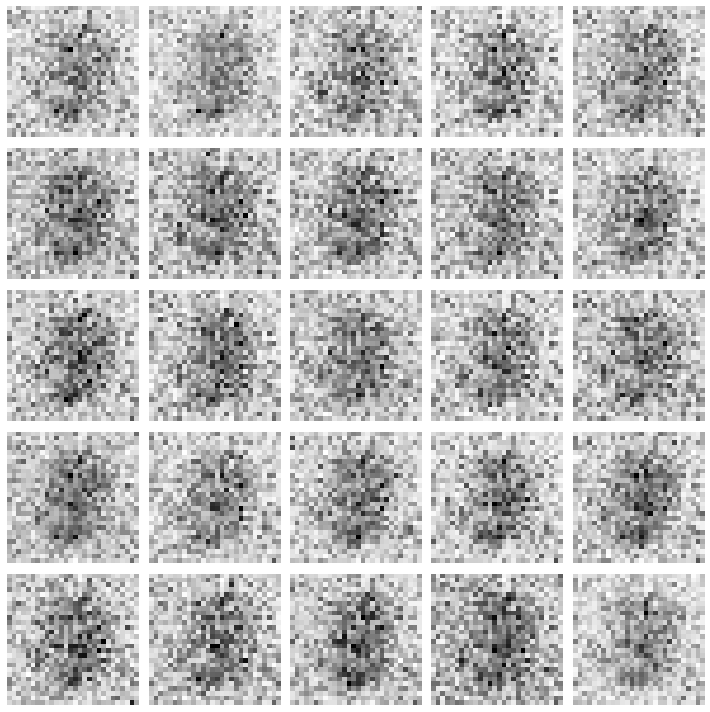

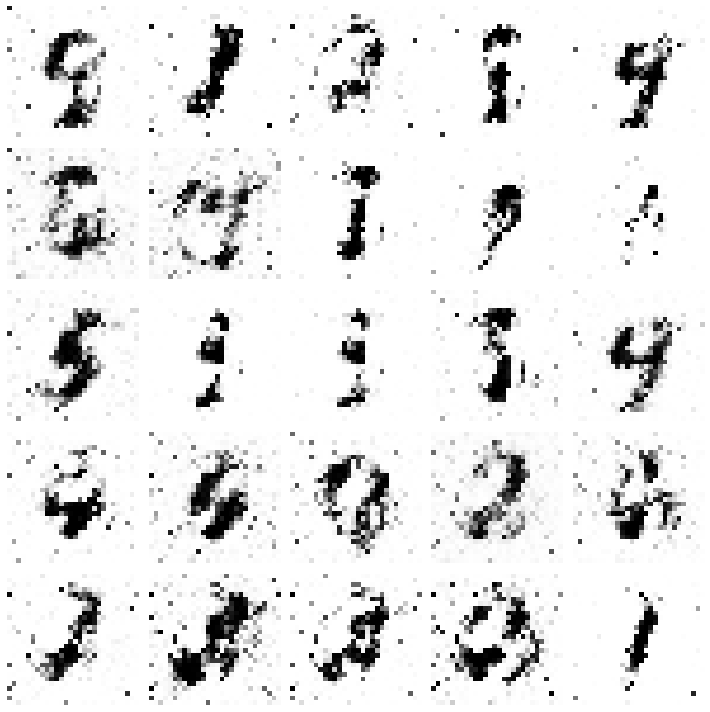

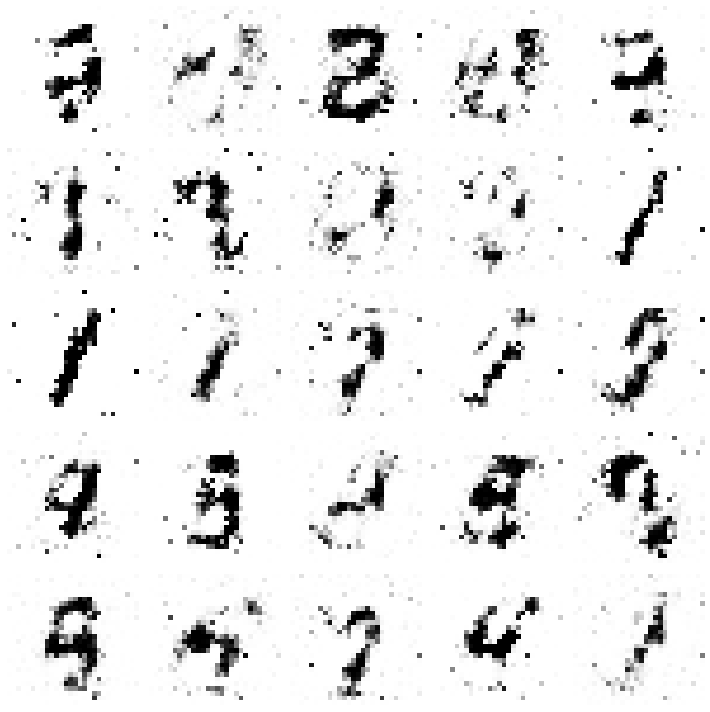

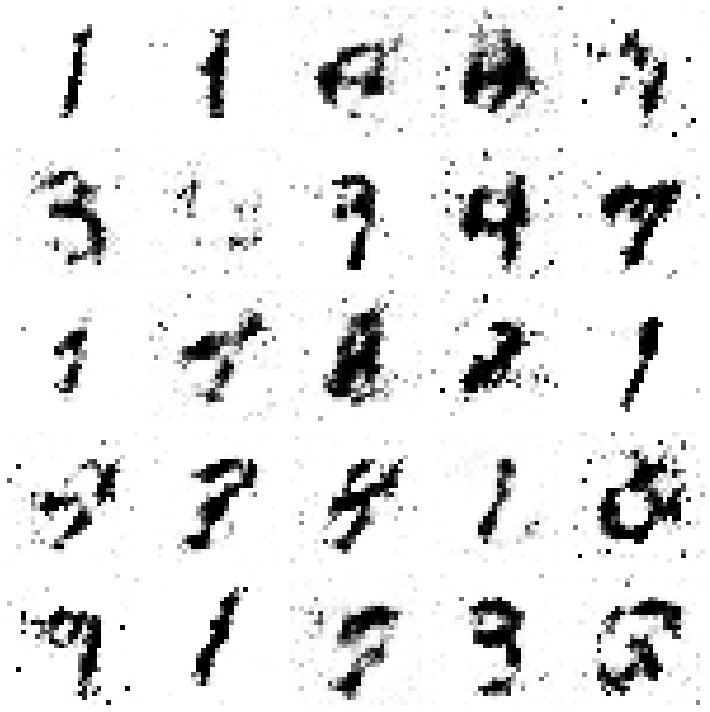

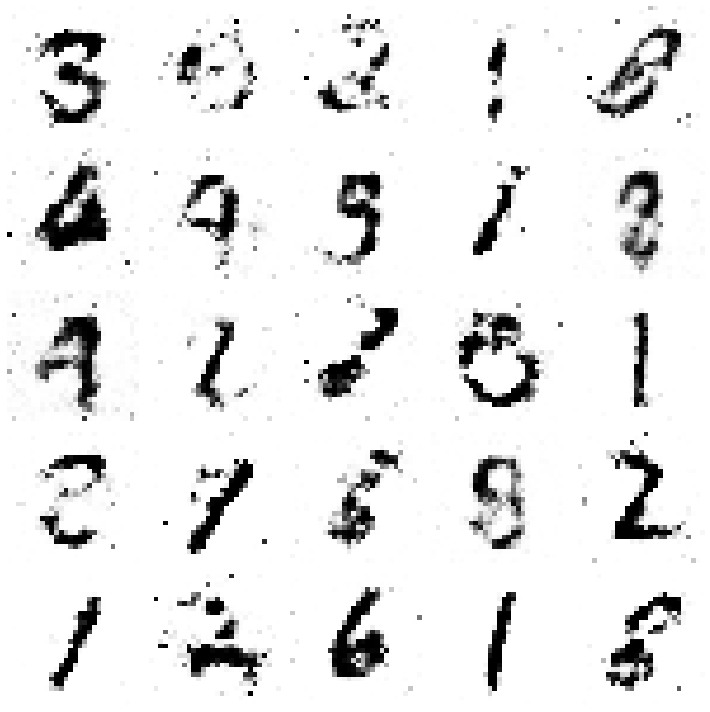

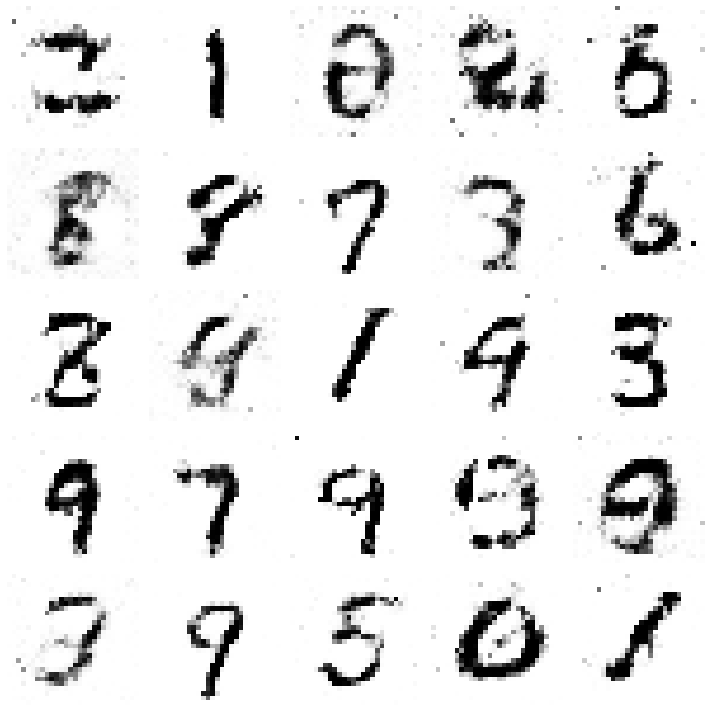

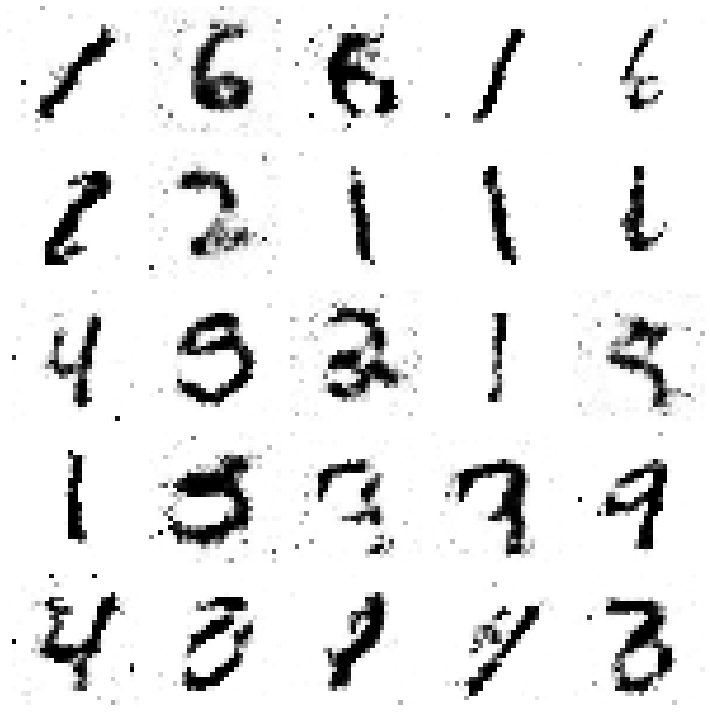

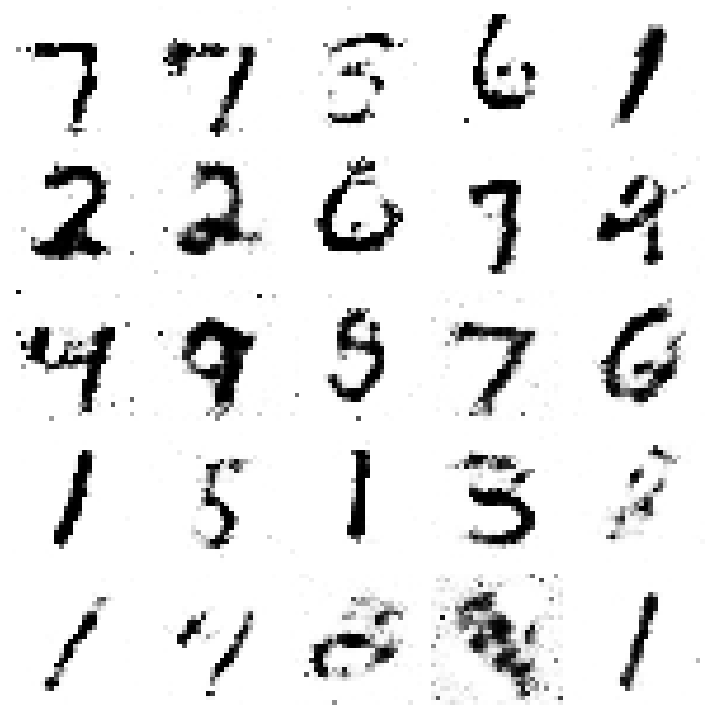

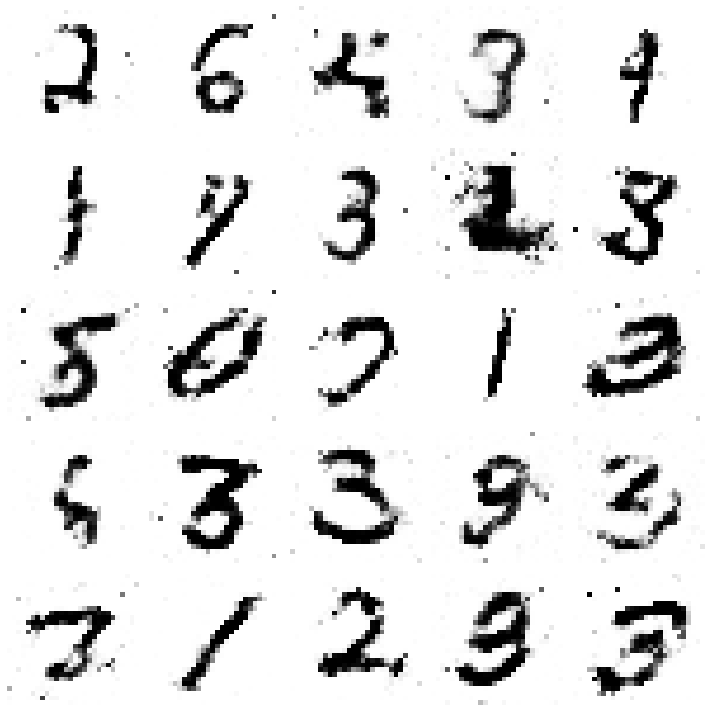

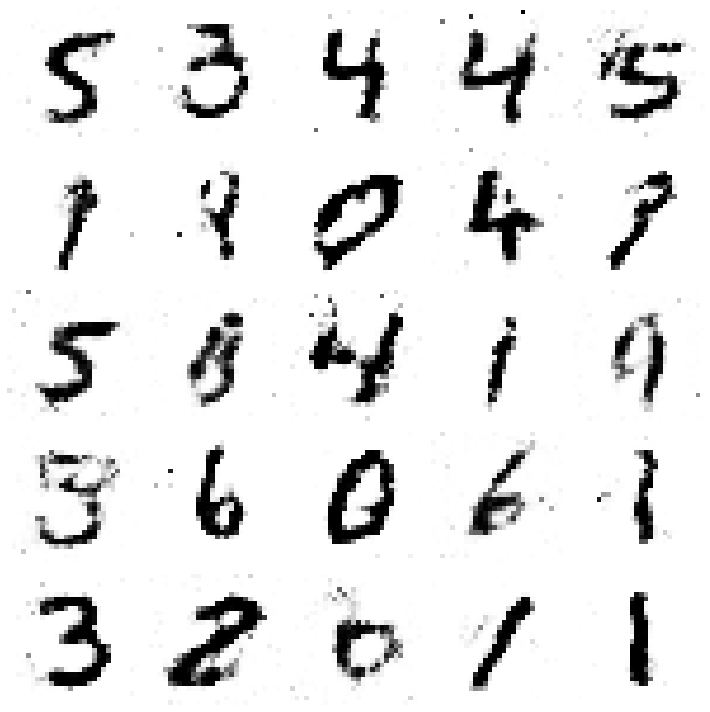

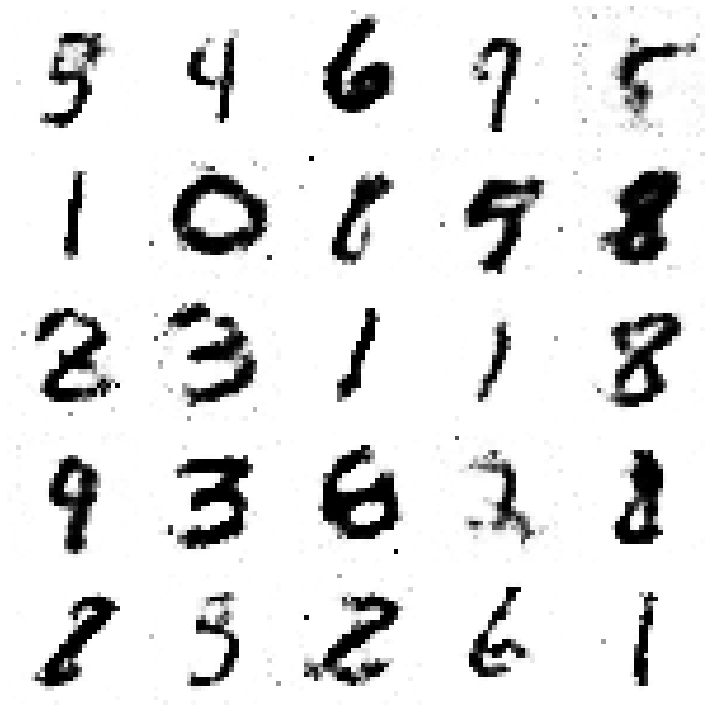

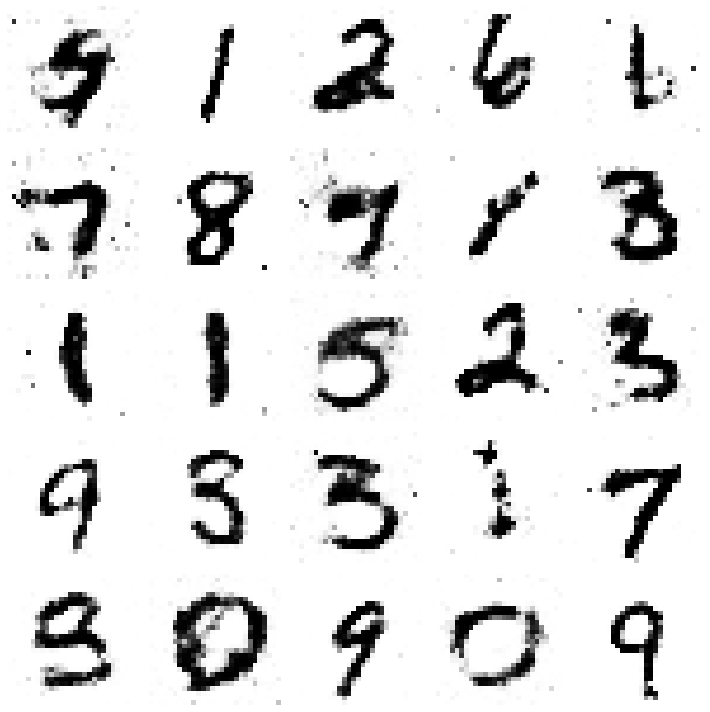

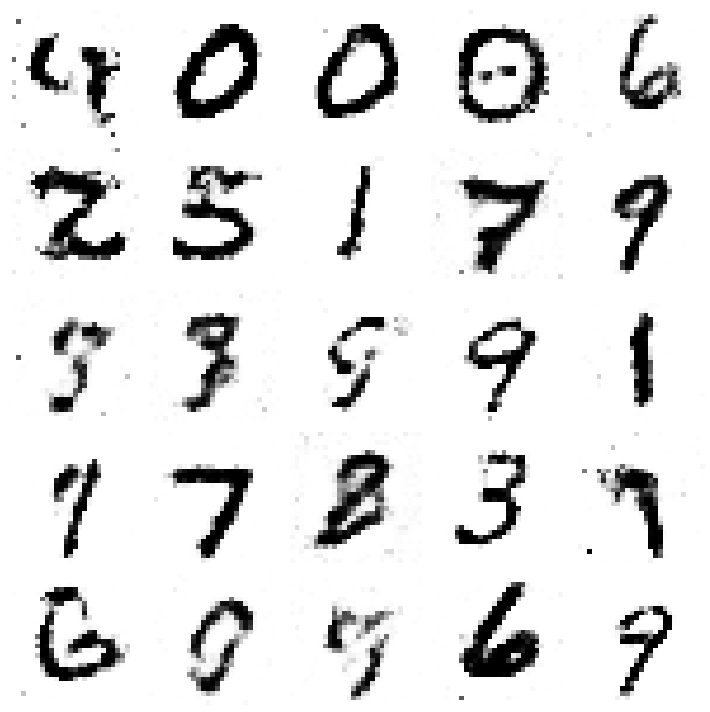

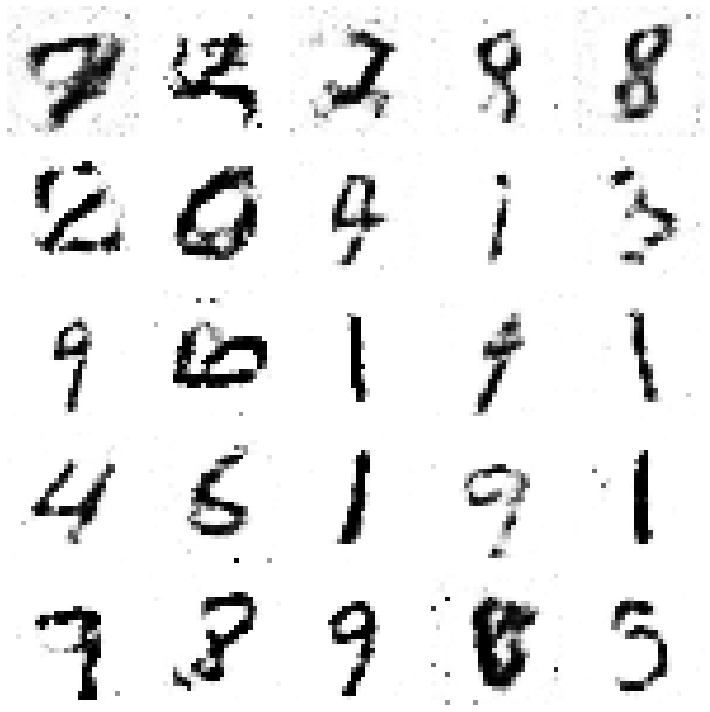

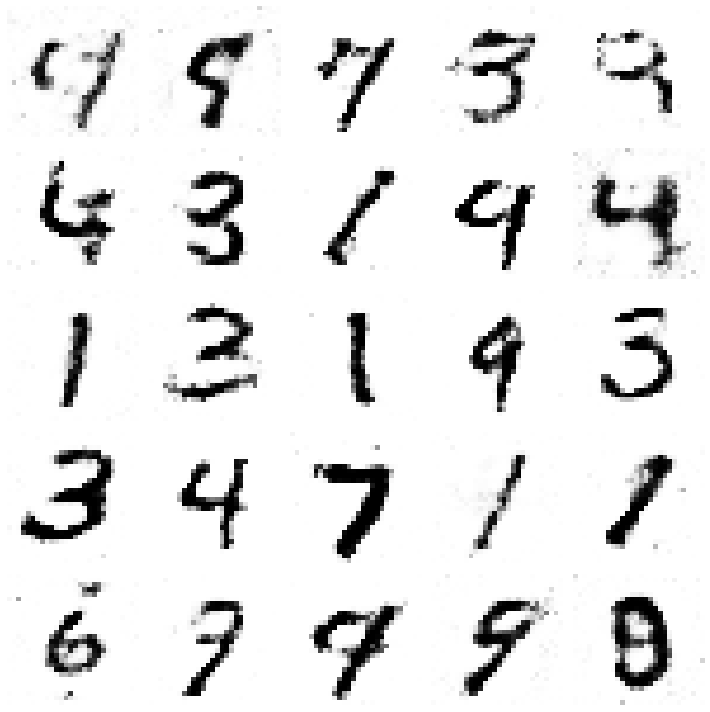

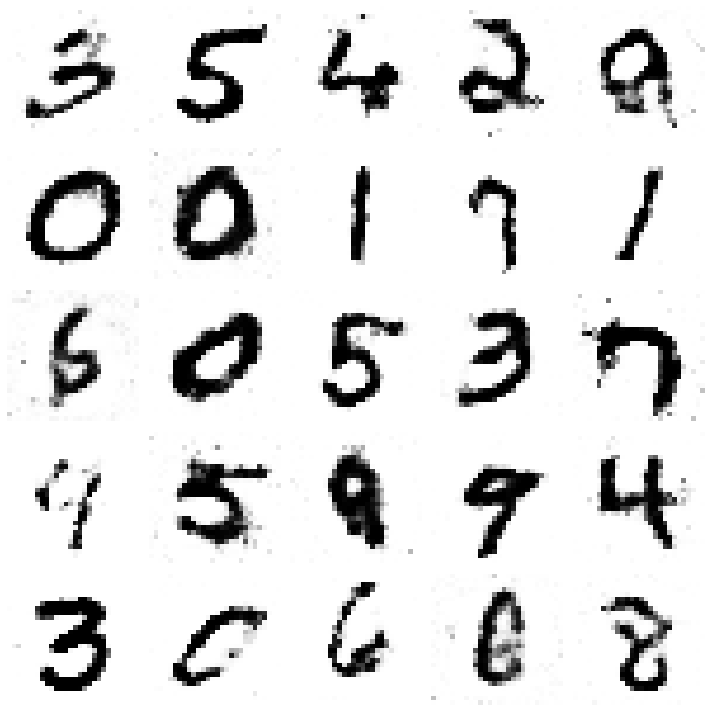

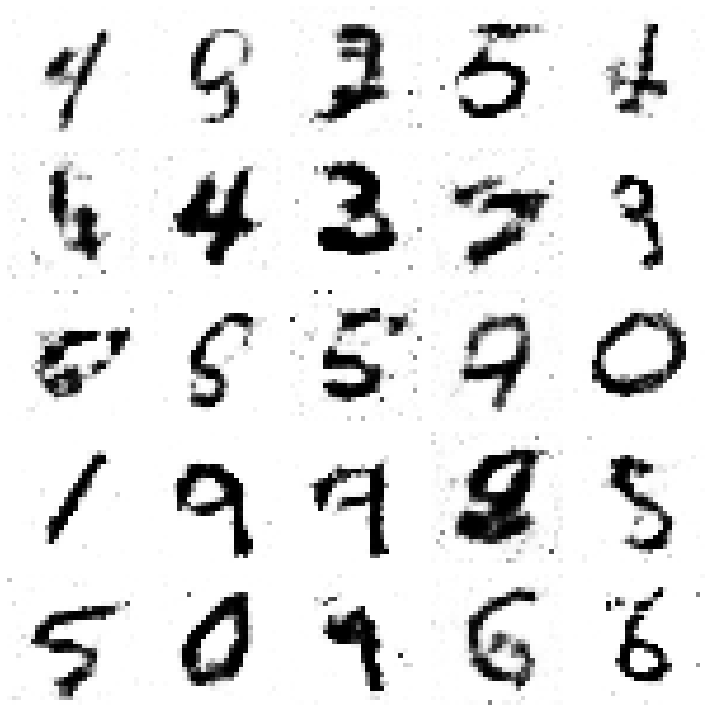

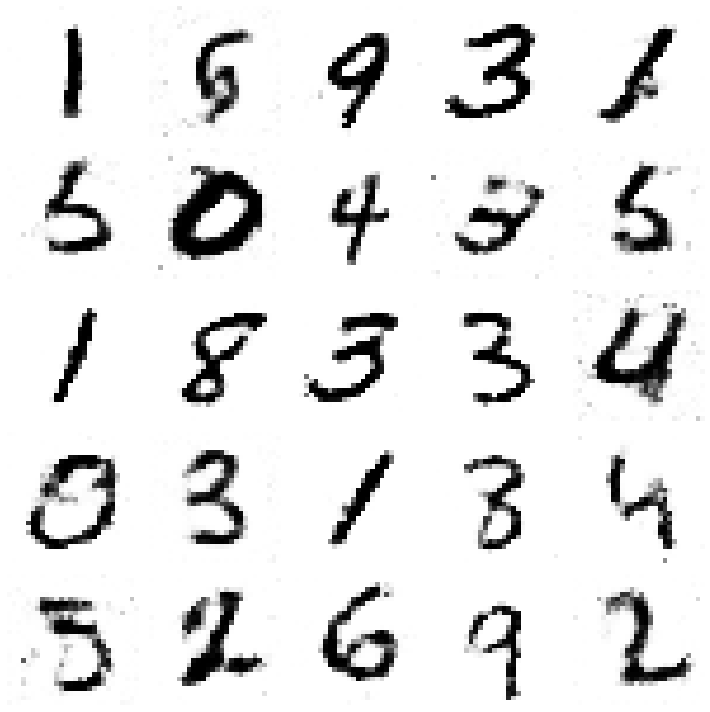

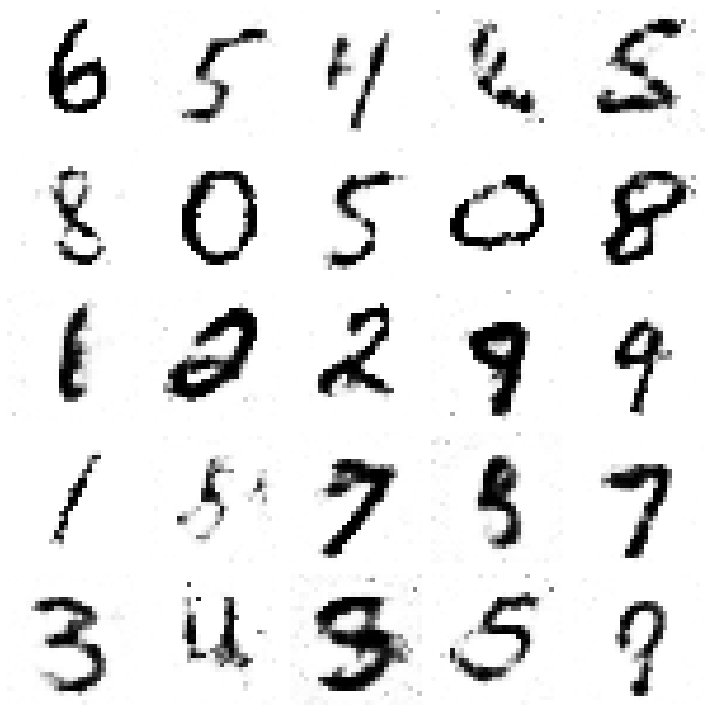

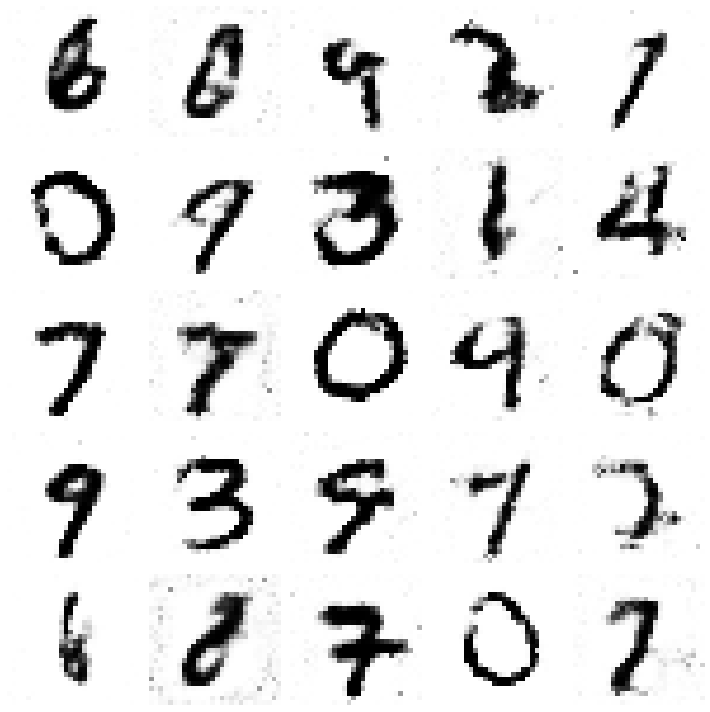

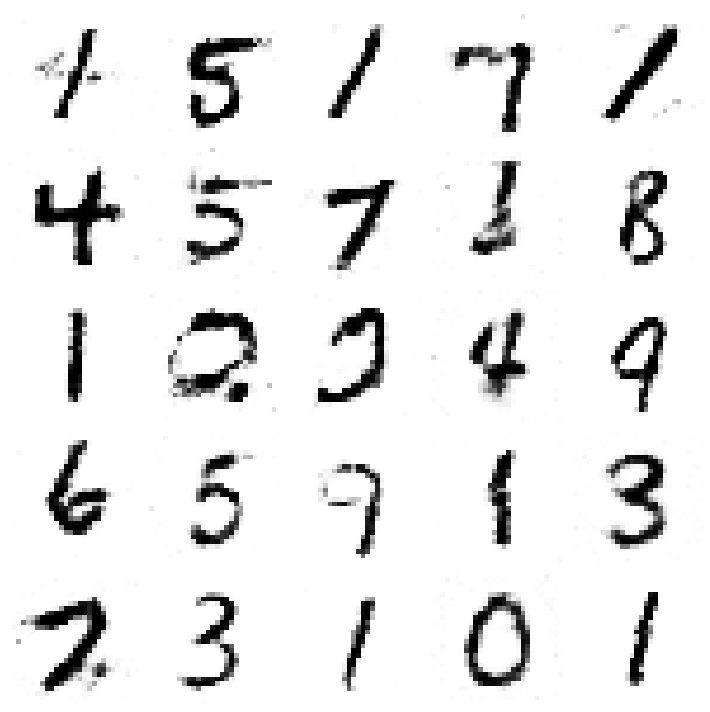

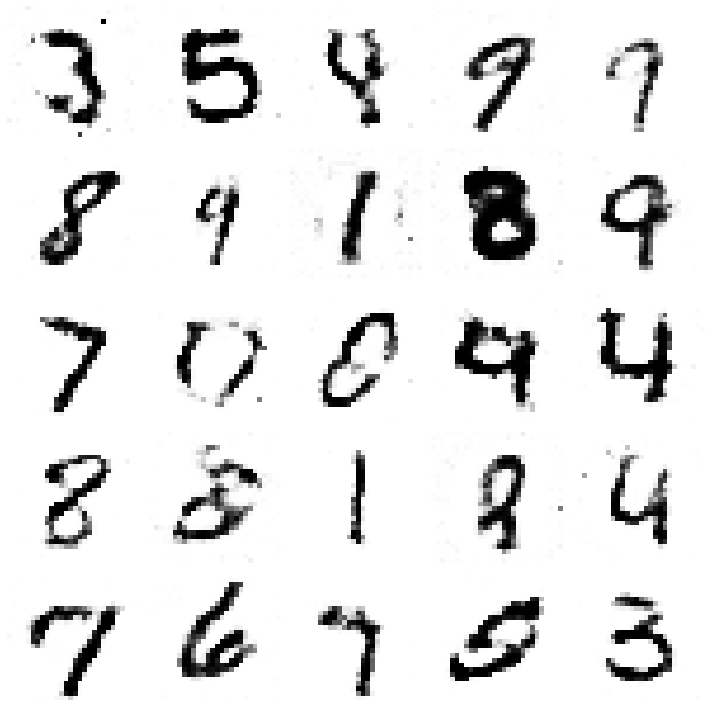

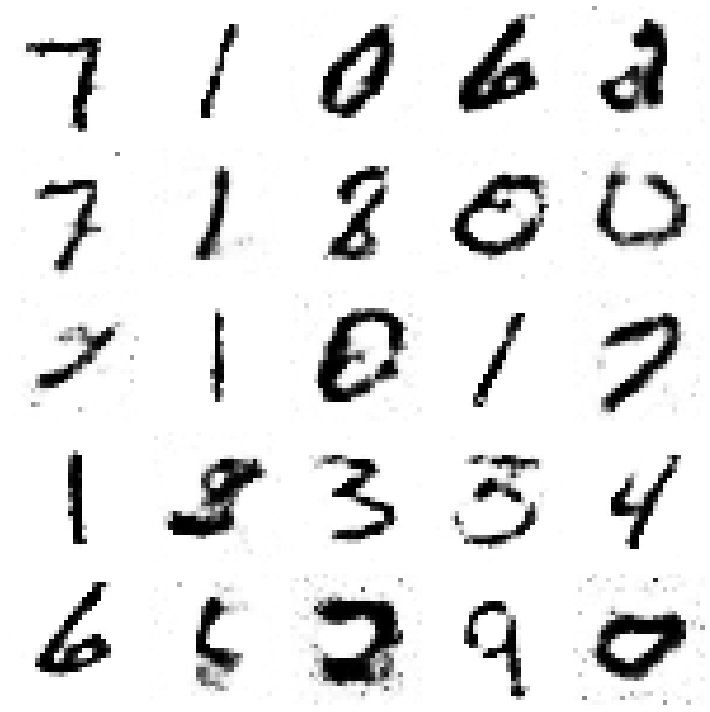

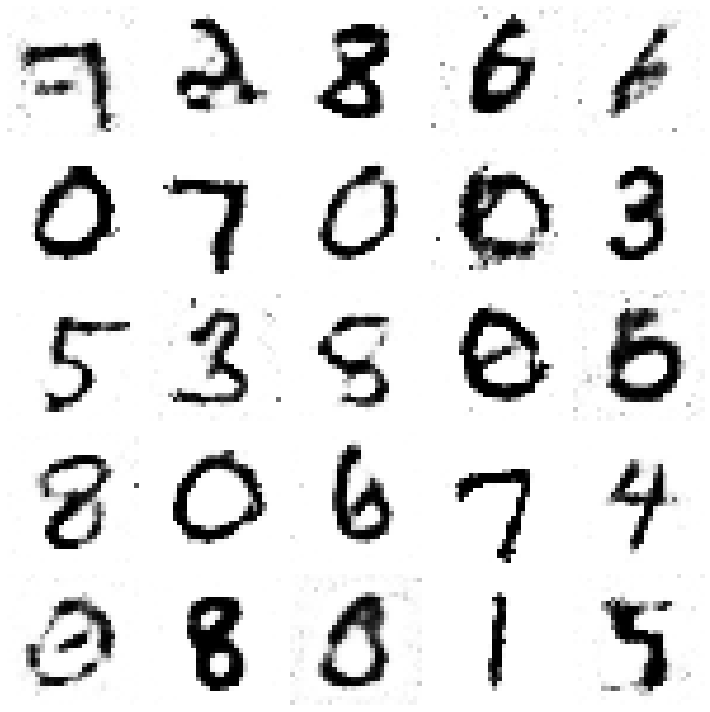

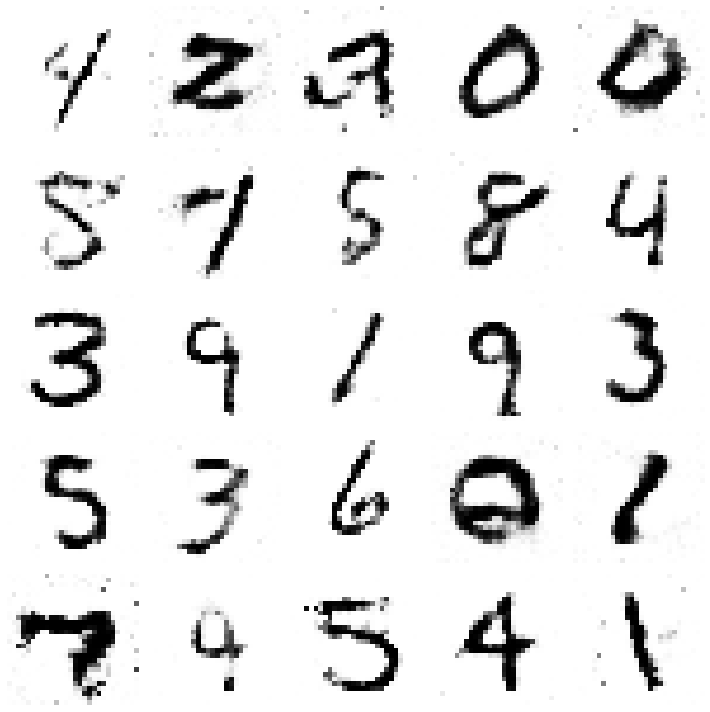

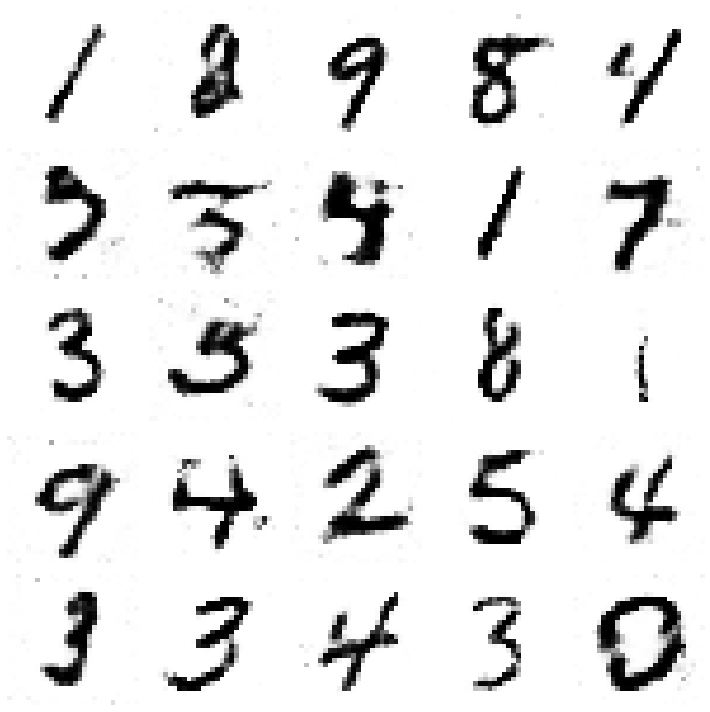

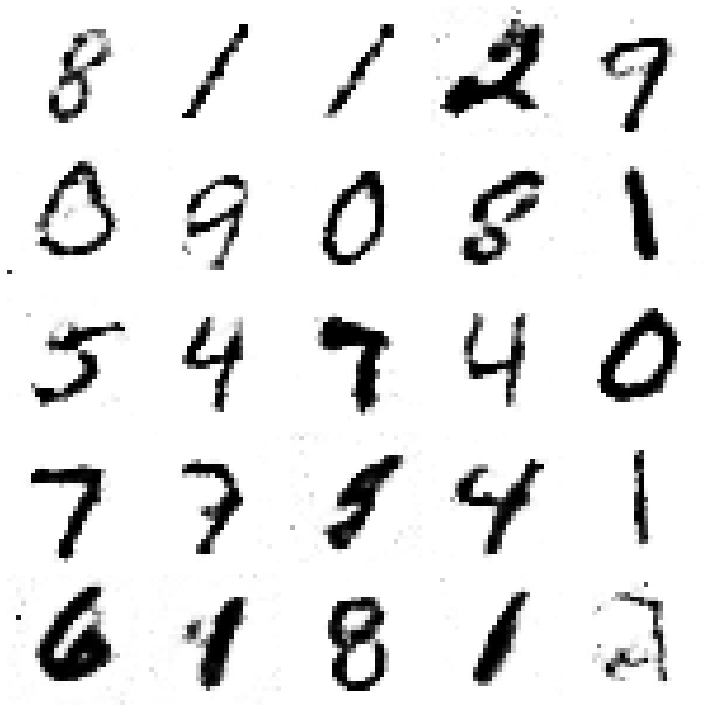

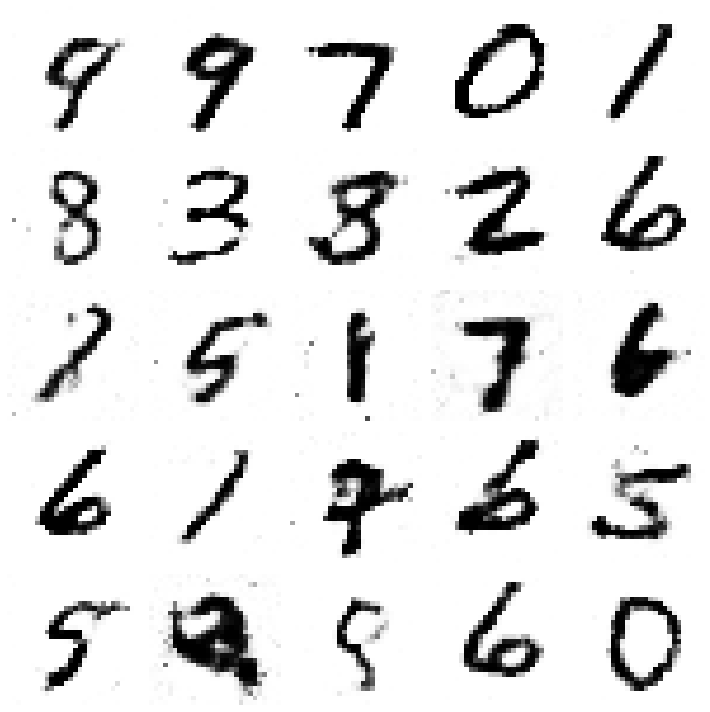

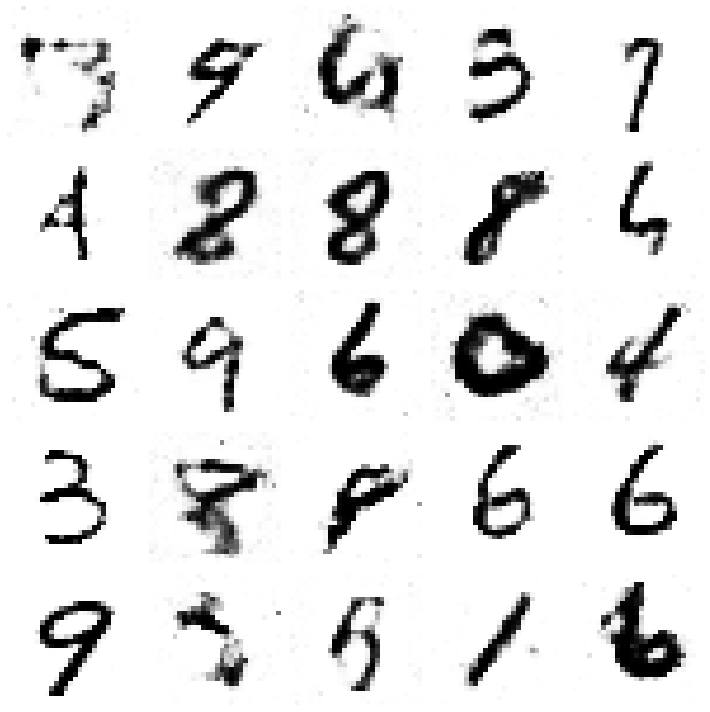

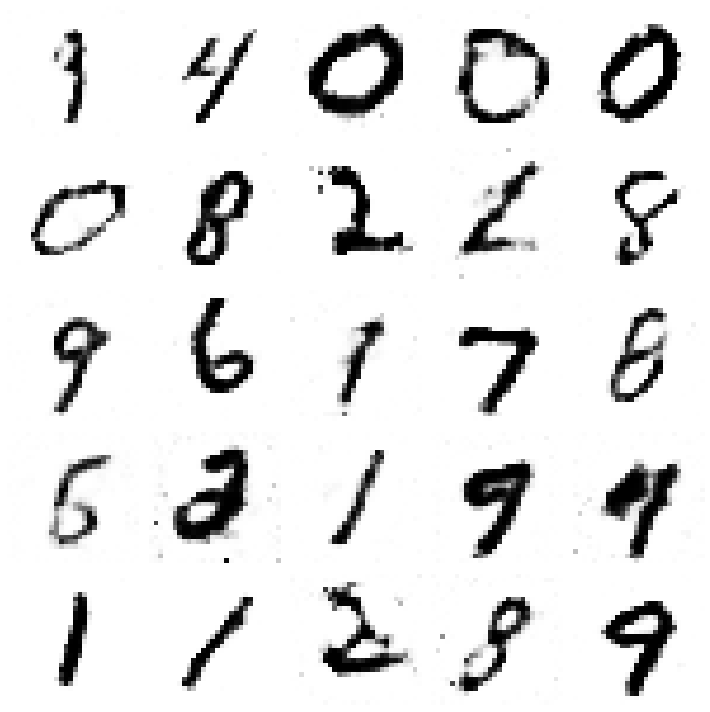

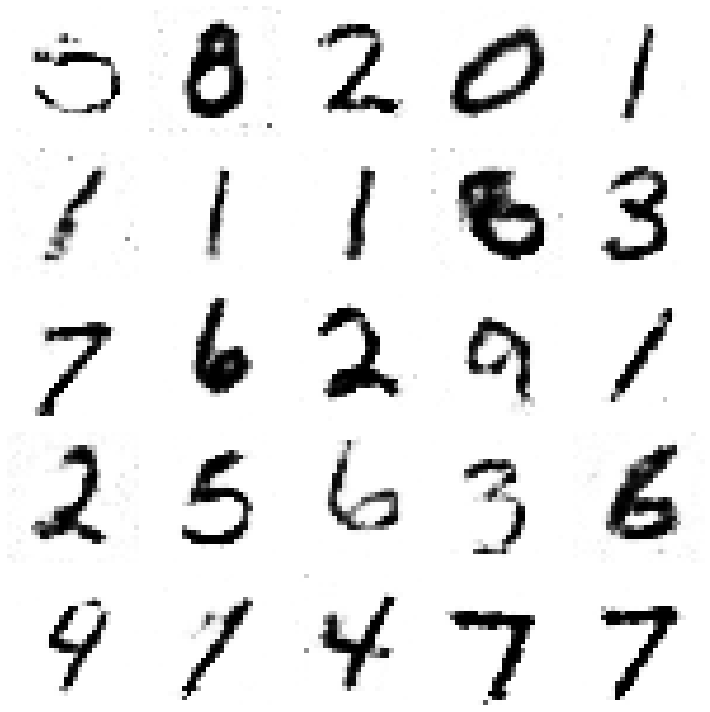

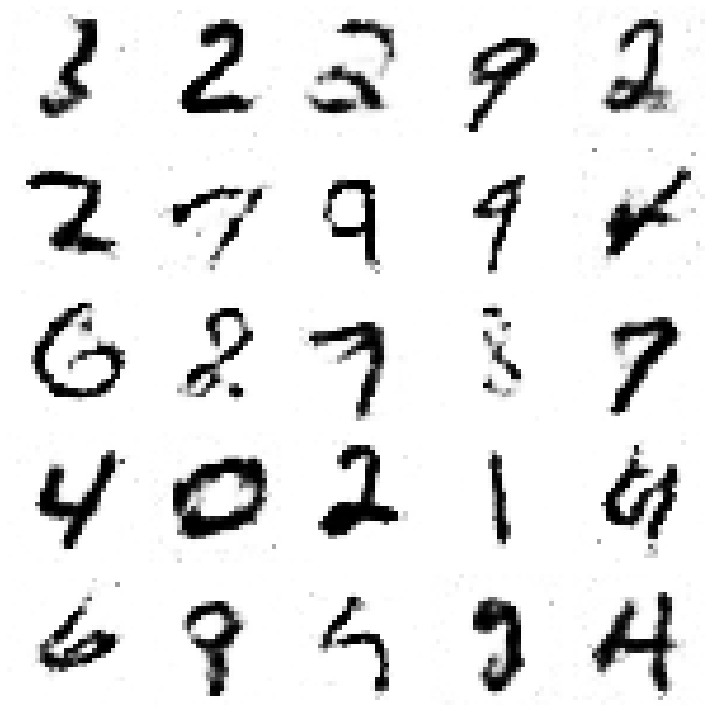

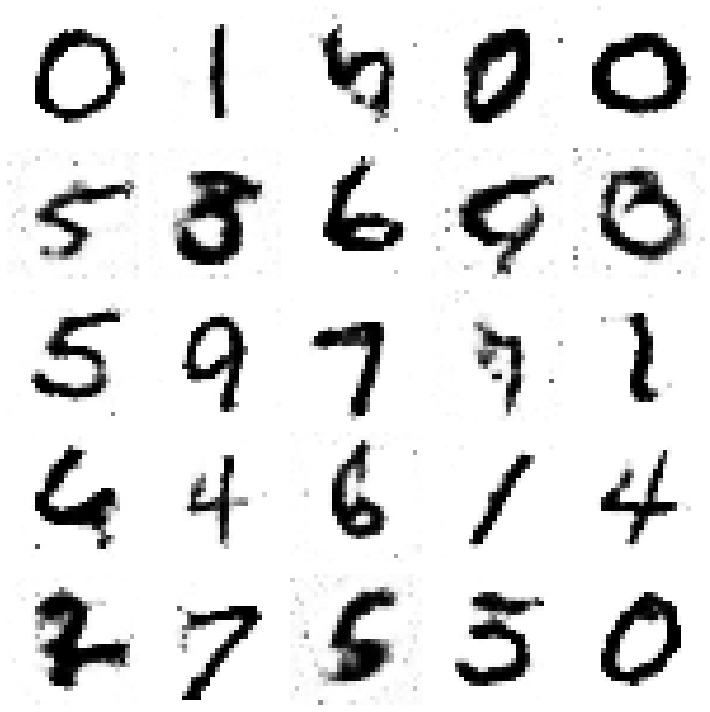

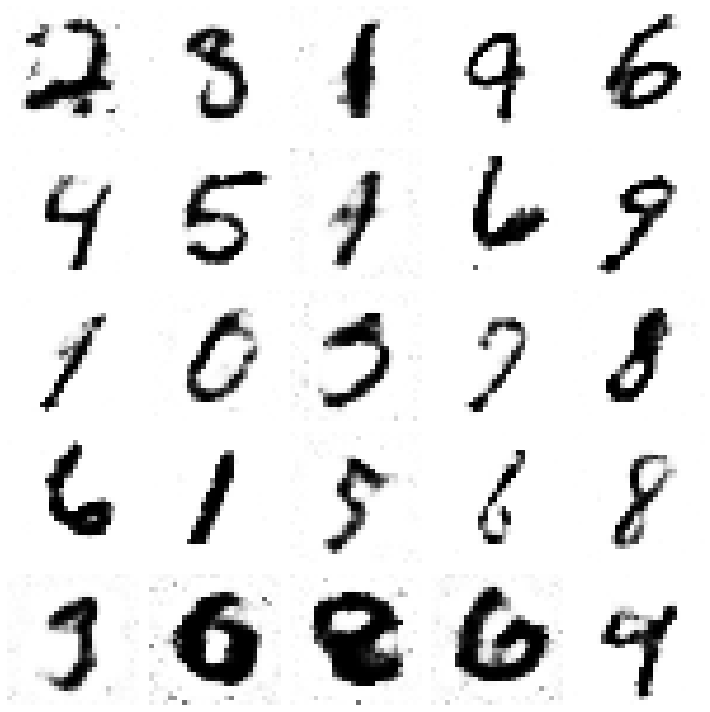

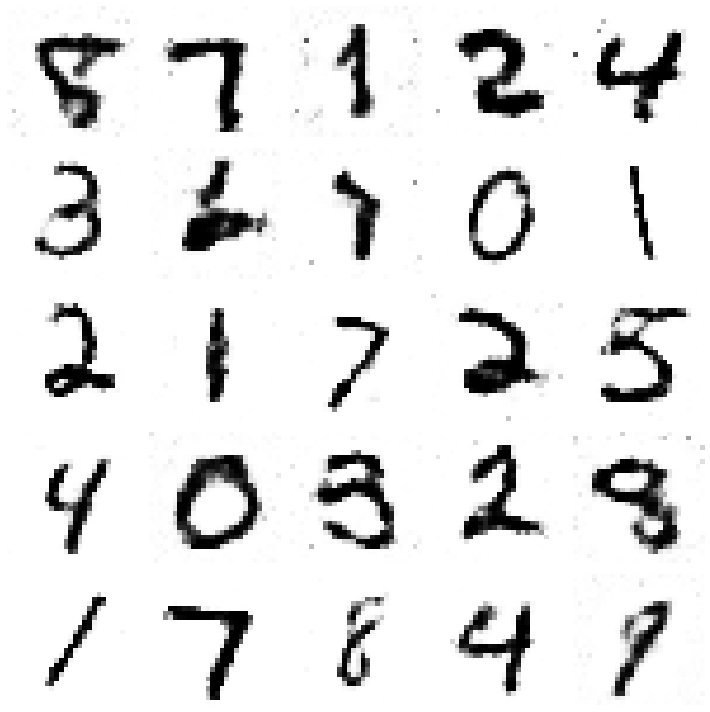

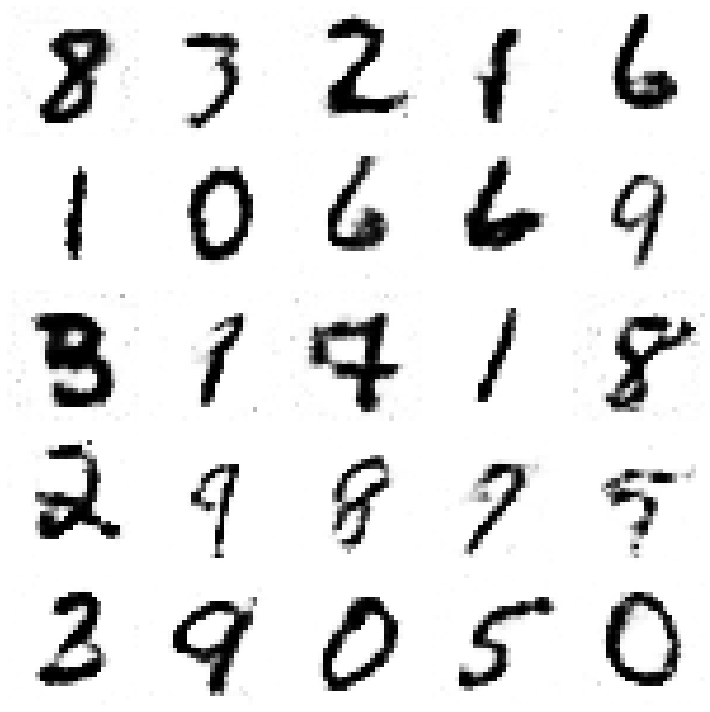

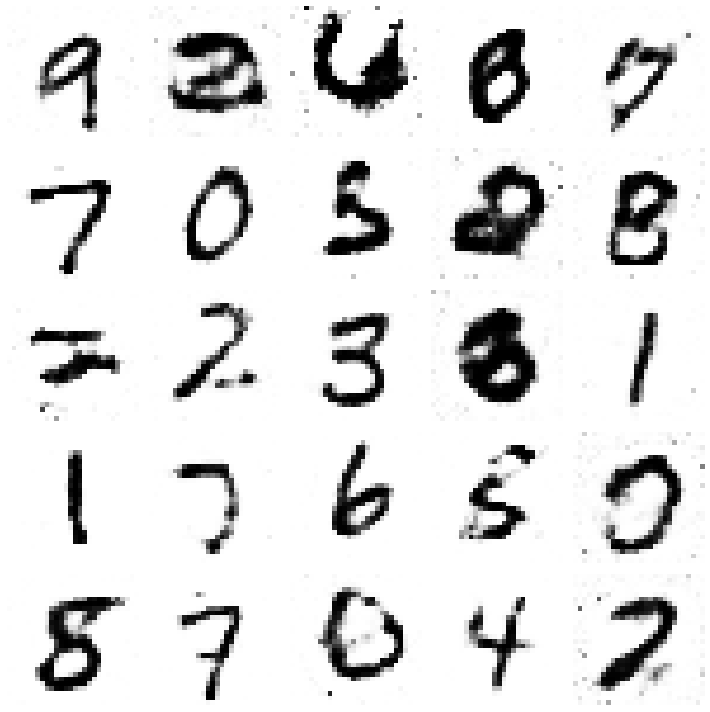

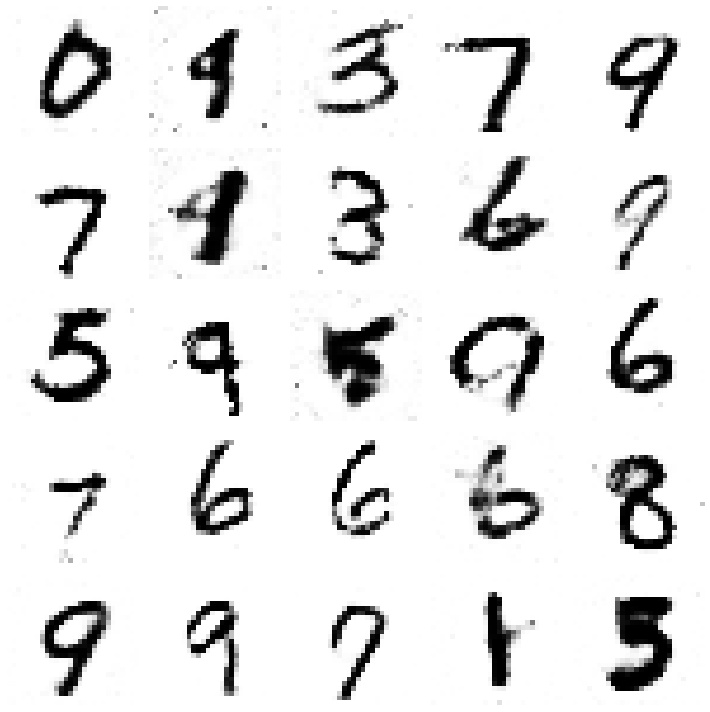

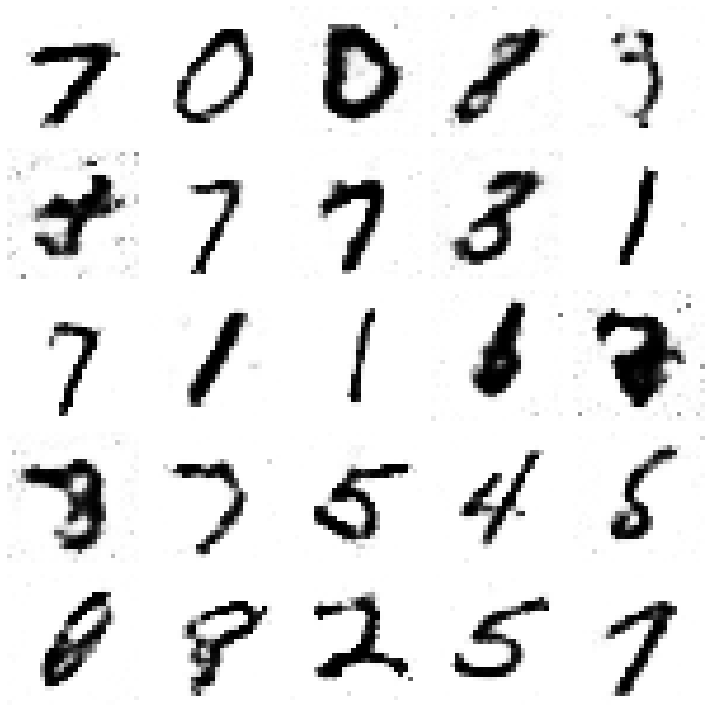

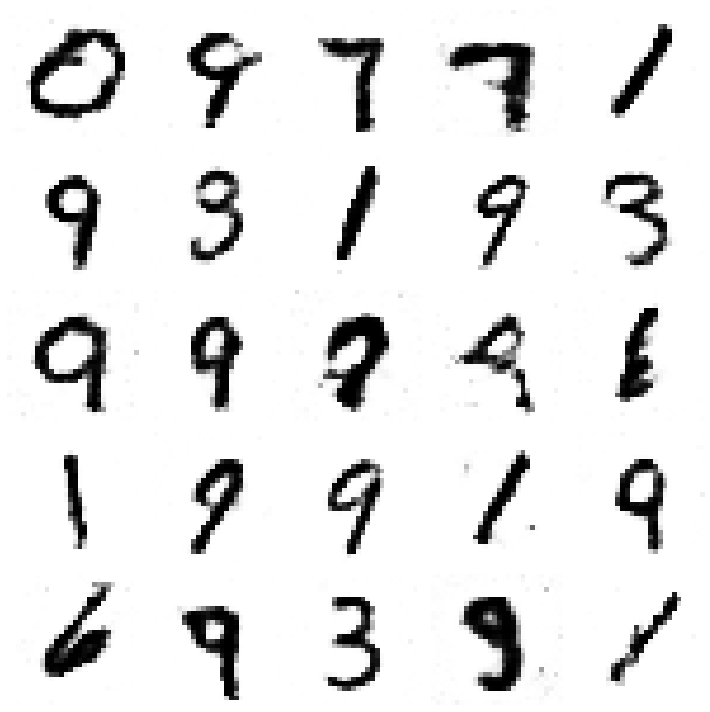

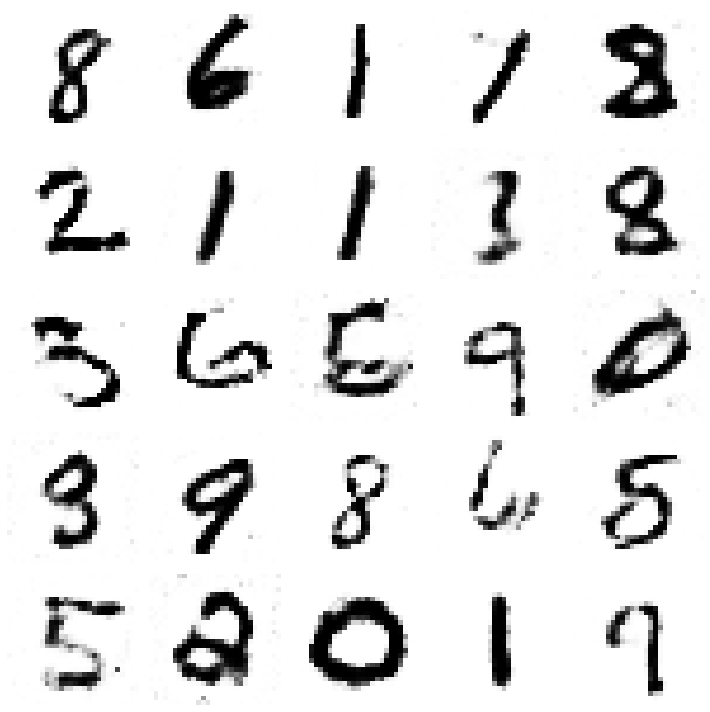

In [ ]:
def train_GAN(epochs=1,batch_size=128):

  X_train,y_train = load_data()

  generator = build_generator()
  discriminator = build_discriminator()
  GAN = build_GAN(discriminator,generator)

  for i in range(1,epochs+1):
    print("Epoch %d" %i)

    for _ in tqdm(range(batch_size)):
      
      noise= np.random.normal(0,1, (batch_size, 100))

      fake_images = generator.predict(noise)
      real_images = X_train[np.random.randint(0, X_train.shape[0] ,batch_size)]

      label_fake = np.zeros(batch_size)
      label_real = np.ones(batch_size)

      X = np.concatenate([fake_images,real_images])
      y = np.concatenate([label_fake,label_real])
      
      discriminator.trainable = True
      discriminator.train_on_batch(X,y)

      discriminator.trainable = False
      GAN.train_on_batch(noise,label_real)

    if i==1 or i%10==0:
      draw_images(generator,i)

train_GAN(epochs=400, batch_size=128)